<a href="https://colab.research.google.com/github/UrmilaAirsang/Pytorch/blob/main/MNIST_highest99_5_10KparamsChangedModel_StepLR_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

#S5F4
Target:
1. Try with different optimizers like Adam, SDG etc
2. Tune optimizer parametrs like LR, weight_decay, gamma, etc.

Results:
1. Parameters: 9.3K
2. Best Training Accuracy: 
3. Best Test Accuracy: 

Analysis:
1.   Tune the LR parameter to reduce the learning rate after every 4 epochs
2.   Training accuracy consistently increased
3.   Droupout is not used because Training accuracy did not get saturated(No overfitting is observed)
4.   Batch normalization is used for every block

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [6]:
import torch.nn.functional as F
dropout_value = 0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
           # nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
           # nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
           # nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
           # nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
           # nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
           # nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
            Conv2d-4           [-1, 16, 24, 24]           1,728
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 12, 24, 24]             192
         MaxPool2d-8           [-1, 12, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,728
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
           Conv2d-12             [-1, 16, 8, 8]           2,304
             ReLU-13             [-1, 16, 8, 8]               0
      BatchNorm2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
#from torch_lr_finder import LRFinder

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.7)
#optimizer = optim.Adam(model.parameters(), lr=0.01)

scheduler = StepLR(optimizer, step_size=4, gamma=0.01)
#scheduler = ReduceLROnPlateau(optimizer, 'min',patience = 2)

EPOCHS = 15
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch-0 lr: 0.1


Loss=0.04086606577038765 Batch_id=468 Accuracy=93.69: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9856/10000 (98.56%)

Epoch-1 lr: 0.1


Loss=0.07154849916696548 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9912/10000 (99.12%)

Epoch-2 lr: 0.1


Loss=0.0801549181342125 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9898/10000 (98.98%)

Epoch-3 lr: 0.1


Loss=0.014494369737803936 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9922/10000 (99.22%)

Epoch-4 lr: 0.001


Loss=0.05249595642089844 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

Epoch-5 lr: 0.001


Loss=0.0028690826147794724 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

Epoch-6 lr: 0.001


Loss=0.007366540376096964 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

Epoch-7 lr: 0.001


Loss=0.004493516404181719 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

Epoch-8 lr: 1e-05


Loss=0.024209901690483093 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)

Epoch-9 lr: 1e-05


Loss=0.00936717540025711 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

Epoch-10 lr: 1e-05


Loss=0.013289798982441425 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9939/10000 (99.39%)

Epoch-11 lr: 1e-05


Loss=0.03566277399659157 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9941/10000 (99.41%)

Epoch-12 lr: 1.0000000000000001e-07


Loss=0.014163368381559849 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9950/10000 (99.50%)

Epoch-13 lr: 1.0000000000000001e-07


Loss=0.021588444709777832 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 27.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)

Epoch-14 lr: 1.0000000000000001e-07


Loss=0.03164583444595337 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]



Test set: Average loss: 0.0177, Accuracy: 9947/10000 (99.47%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

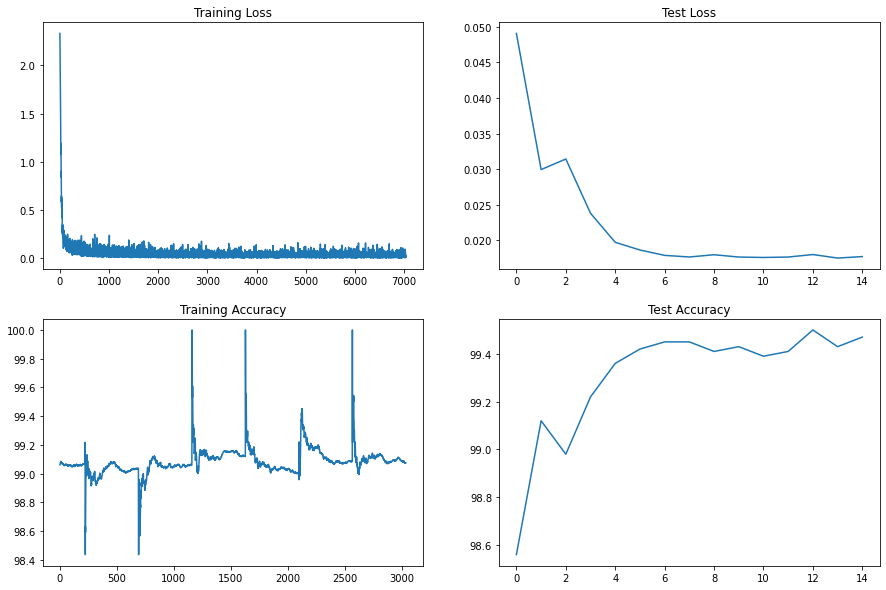

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")